# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("local[*]")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!ls /workspace

data  ml-10m  MLBD  spark-2.4.4-bin-hadoop2.6.tgz


In [5]:
#!hdfs dfs -ls data/ml-10m/

### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = '/workspace/ml-10m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,122,5,838985046',
 '1,185,5,838983525',
 '1,231,5,838983392',
 '1,292,5,838983421']

In [8]:
ratings.getNumPartitions()

7

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

10000054

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 27.6 ms, sys: 7.59 ms, total: 35.2 ms
Wall time: 39.9 s


69878

Сохраним датасет в память

In [10]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 1min 1s


69878

Количество фильмов

In [14]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

10677

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [11]:
movies = sc.textFile('file:///' + MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [12]:
movies_no_genre = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))
movies_no_genre.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [13]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])
movie_avg_rating.take(5)

[(40964, 2.28125),
 (8197, 3.867283950617284),
 (4102, 3.671622769753611),
 (7, 3.365017361111111),
 (4109, 2.5123456790123457)]

In [18]:
movie_avg_rating \
    .join(movies_no_genre) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[("Satan's Tango (Sátántangó) (1994)", 5.0),
 ('Sun Alley (Sonnenallee) (1999)', 5.0),
 ('Shadows of Forgotten Ancestors (1964)', 5.0),
 ('Blue Light', 5.0),
 ('Fighting Elegy (Kenka erejii) (1966)', 5.0),
 ('Human Condition III', 4.75),
 ("Who's Singin' Over There? (a.k.a. Who Sings Over There) (Ko to tamo peva) (1980)",
  4.75),
 ('Human Condition II', 4.75),
 ("Constantine's Sword (2007)", 4.75),
 ('More (1998)', 4.75)]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [ ]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [ ]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [14]:
tags = sc.textFile('file:///' + TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '15,4973,excellent!,1215184630',
 '20,1747,politics,1188263867',
 '20,1747,satire,1188263867',
 '20,2424,chick flick 212,1188263835']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

16529

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

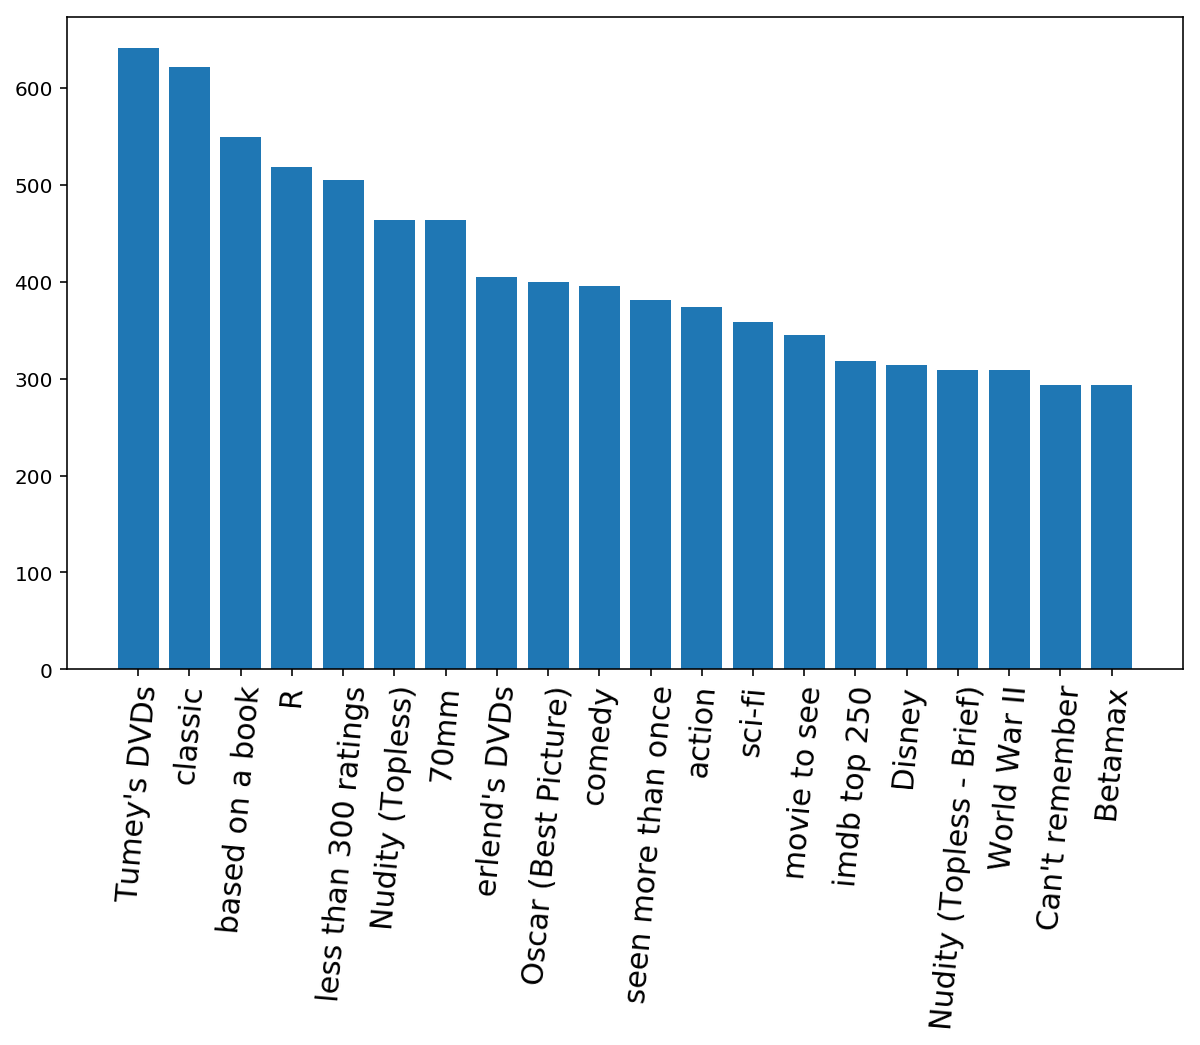

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [17]:
movie_ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)
movie_ratings_count.take(5)

[(40964, 16), (8197, 162), (4102, 1177), (7, 8064), (4109, 243)]

In [22]:
movie_ratings_count \
    .join(movies_no_genre) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[('Pulp Fiction (1994)', 34864),
 ('Forrest Gump (1994)', 34457),
 ('Silence of the Lambs', 33668),
 ('Jurassic Park (1993)', 32631),
 ('Shawshank Redemption', 31126),
 ('Braveheart (1995)', 29154),
 ('Fugitive', 28951),
 ('Terminator 2: Judgment Day (1991)', 28948),
 ('Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)', 28566),
 ('Apollo 13 (1995)', 27035)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [24]:
movie_fives_count = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)
movie_fives_count.take(5)

[(6146, 1), (2051, 23), (8197, 32), (4102, 164), (7, 944)]

In [25]:
movie_fives_count \
    .join(movies_no_genre) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0]))\
    .sortBy(lambda key_value: key_value[1], ascending=False)\
    .take(10)

[('Shawshank Redemption', 16460),
 ('Pulp Fiction (1994)', 14973),
 ('Silence of the Lambs', 13054),
 ("Schindler's List (1993)", 12813),
 ('Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)', 12519),
 ('Forrest Gump (1994)', 11576),
 ('Usual Suspects', 11228),
 ('Braveheart (1995)', 10981),
 ('Godfather', 10553),
 ('Matrix', 9132)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [14]:
avg_ratings = movie_avg_rating \
    .map(lambda key_value: (round(key_value[1], 1), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
avg_ratings[:5]

[(3.3, 743), (1.8, 78), (2.7, 372), (3.2, 761), (1.4, 10)]

In [15]:
avg_ratings = sorted(avg_ratings, key=lambda count: count[1], reverse=True)
avg_ratings[:5]

[(3.5, 809), (3.4, 763), (3.2, 761), (3.6, 758), (3.3, 743)]

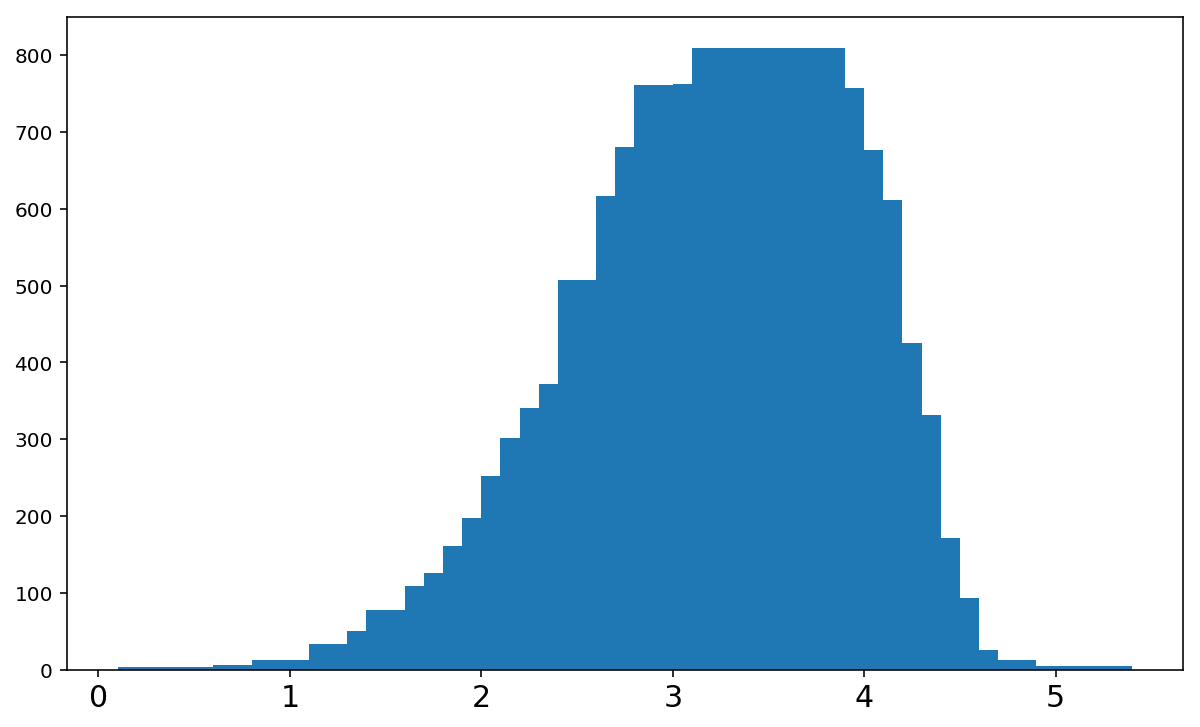

In [16]:
keys, values = zip(*avg_ratings)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [18]:
movie_ratings_count.take(5)

[(40964, 16), (8197, 162), (4102, 1177), (7, 8064), (4109, 243)]

In [19]:
rating_counts = movie_ratings_count\
    .map(lambda key_value: (key_value[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
rating_counts[:5]

[(7168, 1), (5124, 1), (1029, 2), (7, 107), (2058, 1)]

In [26]:
rating_counts = sorted(rating_counts, key=lambda count: count[0], reverse=False)
rating_counts[:5]

[(1, 100), (2, 140), (3, 106), (4, 135), (5, 115)]

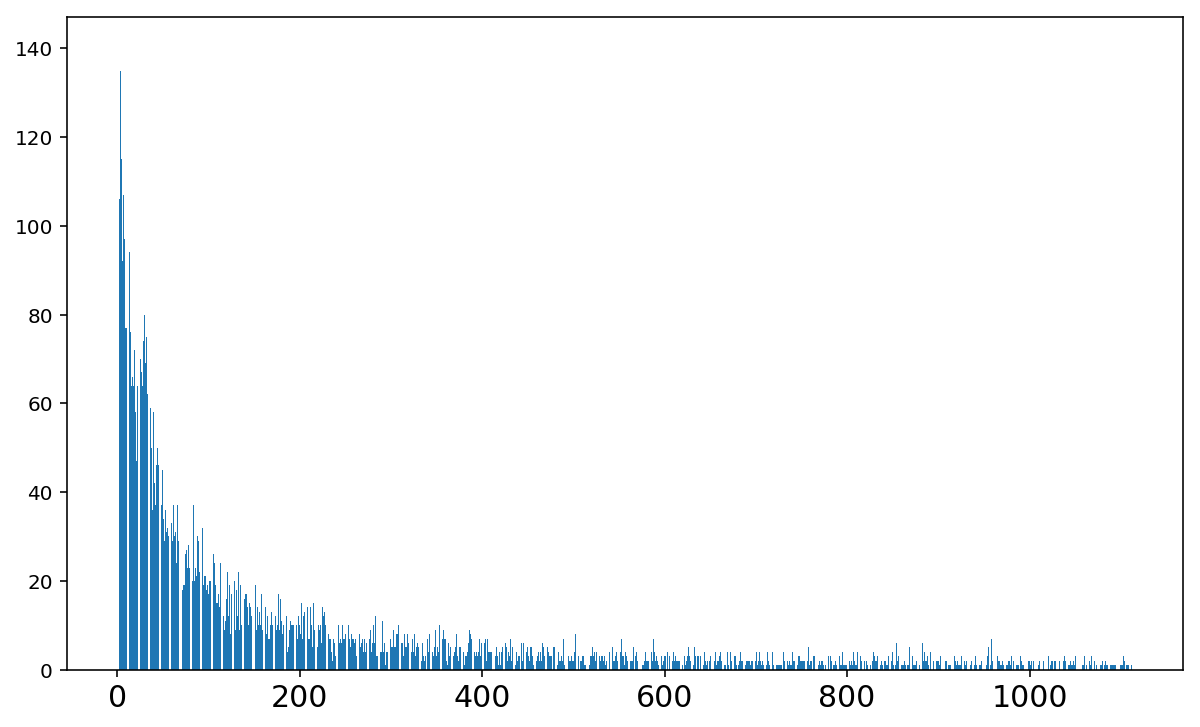

In [29]:
keys, values = zip(*rating_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.bar(keys[:1000], values[:1000], align="center")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [19]:
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [82]:
genres_counts = movies\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))\
    .flatMap(lambda key_value: key_value[1][-1].split('|'))\
    .map(lambda key_value: (key_value, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()
genres_counts[:5]

[('Sci-Fi', 754),
 ('Horror', 1013),
 ('Drama', 5339),
 ('Action', 1473),
 ('Western', 275)]

In [83]:
genres_counts = sorted(genres_counts, key=lambda count: count[1], reverse=True)
genres_counts[:5]

[('Drama', 5339),
 ('Comedy', 3703),
 ('Thriller', 1706),
 ('Romance', 1685),
 ('Action', 1473)]

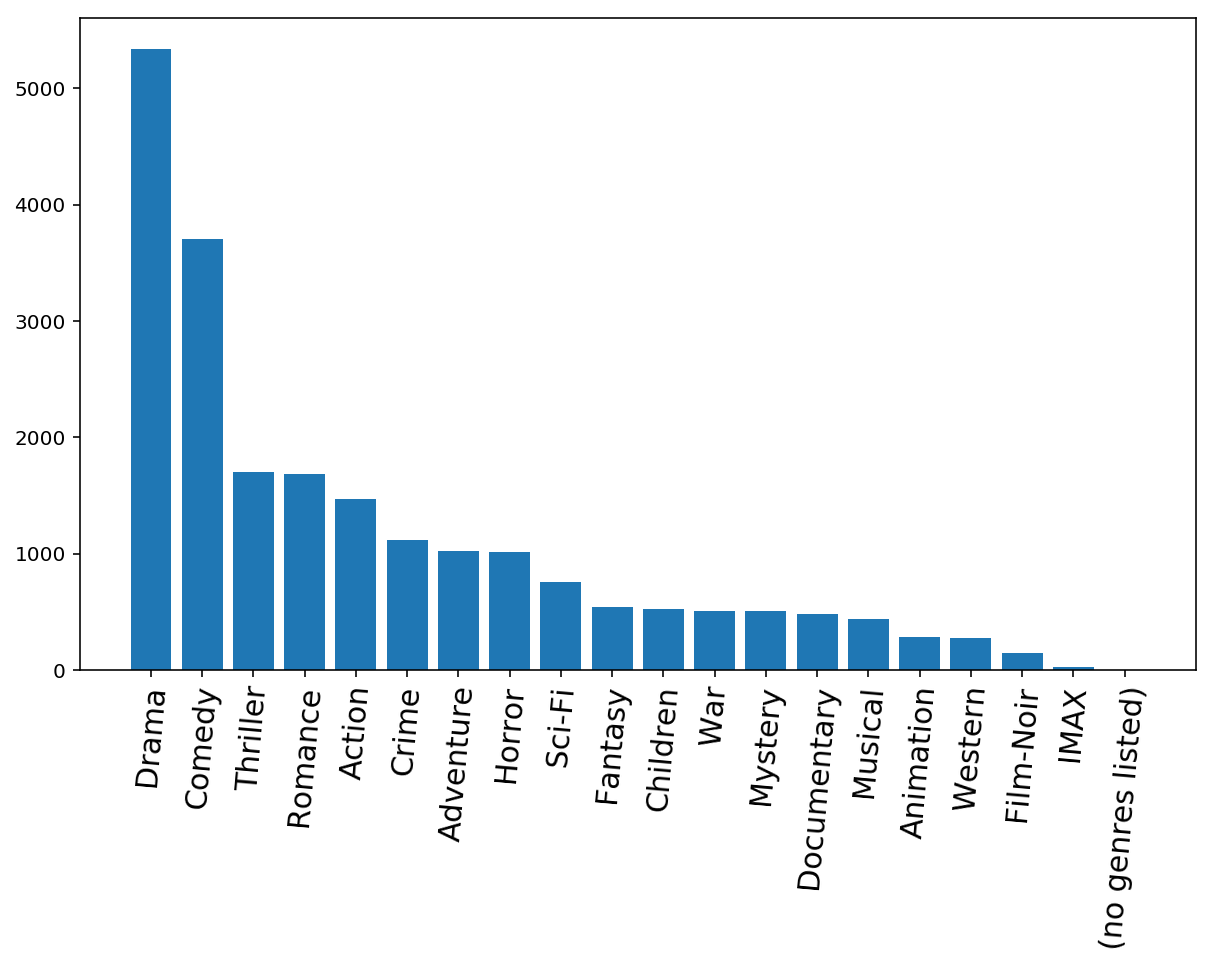

In [85]:
keys, values = zip(*genres_counts)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys[:50], values[:50], align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [30]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
links = sc.textFile('file:///' + LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [31]:
movies_ids = movies_no_genre\
    .map(lambda key_value: key_value[1][0])\
    .collect()
movies_ids[:5]

['1', '2', '3', '4', '5']

In [32]:
links = links\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit() and arr[0] in movies_ids and arr[-1].isdigit()) \
    .map(lambda arr: (arr[0], int(arr[-1]))) \
    .keyBy(lambda arr: int(arr[0]))
links.take(5)

[(1, ('1', 862)),
 (2, ('2', 8844)),
 (3, ('3', 15602)),
 (4, ('4', 31357)),
 (5, ('5', 11862))]

In [33]:
tmdb_ids = links\
    .map(lambda key_value: key_value[1][1])\
    .collect()
tmdb_ids[:5]

[862, 8844, 15602, 31357, 11862]

In [34]:
tmdb_names = links\
    .join(movies_no_genre)\
    .map(lambda key_value: [key_value[1][0][1], key_value[1][1][1]])\
    .keyBy(lambda arr: arr[0])
tmdb_names.take(5)

[(89992, [89992, 'Curse']),
 (48561, [48561, 'Traviata']),
 (8966, [8966, 'Twilight (2008)']),
 (31357, [31357, 'Waiting to Exhale (1995)']),
 (44708, [44708, 'Blue Gate Crossing (Lanse da Men) (2002)'])]

In [35]:
import json
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sc.textFile('file:///' + TMDB_PATH)\
    .map(lambda s: json.loads(s))\
    .filter(lambda rec: rec.get('id', None) in tmdb_ids)\
    .keyBy(lambda rec: rec['id'])
tmdb.take(1)

[(862,
  {'adult': False,
   'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
   'belongs_to_collection': {'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg',
    'id': 10194,
    'name': 'Toy Story Collection',
    'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg'},
   'budget': 30000000,
   'casts': {'cast': [{'cast_id': 14,
      'character': 'Woody (voice)',
      'credit_id': '52fe4284c3a36847f8024f95',
      'gender': 2,
      'id': 31,
      'name': 'Tom Hanks',
      'order': 0,
      'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
     {'cast_id': 15,
      'character': 'Buzz Lightyear (voice)',
      'credit_id': '52fe4284c3a36847f8024f99',
      'gender': 2,
      'id': 12898,
      'name': 'Tim Allen',
      'order': 1,
      'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
     {'cast_id': 16,
      'character': 'Mr. Potato Head (voice)',
      'credit_id': '52fe4284c3a36847f8024f9d',
      'gender': 2,
      'id': 7167,
      'name': 'Don Rickles',
      'or

In [36]:
tmdb.count()

10563

 Tom Hanks

In [68]:
actors = tmdb\
    .filter(lambda key_value: key_value[0] in tmdb_ids)\
    .flatMapValues(lambda rec: rec['casts']['cast'])\
    .keyBy(lambda arr: int(arr[1].get('id', None)))\
    .filter(lambda key_value: key_value[0] != None)\
    .mapValues(lambda arr: (arr[0], arr[1]['name']))
actors.take(3)

[(31, (862, 'Tom Hanks')),
 (12898, (862, 'Tim Allen')),
 (7167, (862, 'Don Rickles'))]

In [69]:
actors.count()

214582

In [73]:
hanks_movies = actors\
    .filter(lambda key_value: key_value[0] == 31)\
    .map(lambda key_value: key_value[1][0])\
    .collect()
hanks_movies[:5]

[862, 568, 13, 9800, 858]

In [75]:
hanks = tmdb_names\
    .filter(lambda key_value: key_value[0] in hanks_movies)\
    .map(lambda arr: arr[1][1])\
    .collect()
hanks

['Forrest Gump (1994)',
 'Philadelphia (1993)',
 "Charlie Wilson's War (2007)",
 'Man with One Red Shoe',
 'Road to Perdition (2002)',
 'Saving Private Ryan (1998)',
 "'burbs",
 'Splash (1984)',
 "You've Got Mail (1998)",
 'Simpsons Movie',
 'Punchline (1988)',
 'Toy Story (1995)',
 'Turner & Hooch (1989)',
 'Polar Express',
 'Terminal',
 'Big (1988)',
 'Cars (2006)',
 'Catch Me If You Can (2002)',
 'Volunteers (1985)',
 'Celluloid Closet',
 'Bachelor Party (1984)',
 'Apollo 13 (1995)',
 'Dragnet (1987)',
 'That Thing You Do! (1996)',
 'Nothing in Common (1986)',
 'Return with Honor (1998)',
 'Radio Flyer (1992)',
 'Toy Story 2 (1999)',
 'Bonfire of the Vanities (1990)',
 'Cast Away (2000)',
 'Ladykillers',
 'Sleepless in Seattle (1993)',
 'Da Vinci Code',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Money Pit',
 'Green Mile',
 'League of Their Own',
 'Joe Versus the Volcano (1990)']

Востребованные актеры

In [80]:
actors\
    .mapValues(lambda arr: (arr[1], 1))\
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1]))\
    .map(lambda key_value: (key_value[1][0], key_value[1][1]))\
    .sortBy(lambda arr: arr[1], ascending=False)\
    .take(10)

[('Bess Flowers', 105),
 ('Frank Welker', 87),
 ('Samuel L. Jackson', 76),
 ('Steve Buscemi', 64),
 ('Michael Caine', 63),
 ('Robert De Niro', 63),
 ('Harvey Keitel', 60),
 ('Gene Hackman', 59),
 ('Bruce Willis', 59),
 ('John Wayne', 58)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [37]:
genres = movies\
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: (int(arr[0]), arr[-1].split('|')))\
    .flatMap(lambda arr: map(lambda genre: (arr[0], genre), arr[1]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])
genres.take(5)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy')]

In [38]:
genres_names = genres.map(lambda arr: arr[1]).distinct().collect()
genres_ids = {g:i for i, g in enumerate(genres_names)}
genres_ids

{'(no genres listed)': 14,
 'Action': 3,
 'Adventure': 19,
 'Animation': 17,
 'Children': 5,
 'Comedy': 12,
 'Crime': 15,
 'Documentary': 7,
 'Drama': 2,
 'Fantasy': 9,
 'Film-Noir': 13,
 'Horror': 1,
 'IMAX': 11,
 'Musical': 6,
 'Mystery': 18,
 'Romance': 10,
 'Sci-Fi': 0,
 'Thriller': 8,
 'War': 16,
 'Western': 4}

In [39]:
genres_tmdb = genres\
    .join(links)\
    .map(lambda arr: (arr[1][1][1], arr[1][0]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])
genres_tmdb.take(5)

[(89992, 'Horror'),
 (89992, 'Sci-Fi'),
 (31357, 'Comedy'),
 (31357, 'Drama'),
 (31357, 'Romance')]

In [90]:
years = tmdb\
    .filter(lambda key_value: key_value[1].get('release_date', None) != None and key_value[1]['release_date'] != '')\
    .mapValues(lambda rec: rec['release_date'][:4])\
    .join(genres_tmdb)
years.take(5)

[(16384, ('1990', 'Comedy')),
 (1024, ('1994', 'Crime')),
 (1024, ('1994', 'Drama')),
 (1024, ('1994', 'Fantasy')),
 (1024, ('1994', 'Romance'))]

In [120]:
year_genre = years\
    .map(lambda arr: (arr[1][0], arr[1][1]))\
    .keyBy(lambda arr: (arr[0], arr[1]))\
    .mapValues(lambda arr: 1)\
    .reduceByKey(lambda a, b: a + b)
year_genre.take(5)

[(('1981', 'Romance'), 16),
 (('1972', 'War'), 2),
 (('1990', 'Fantasy'), 12),
 (('1984', 'Film-Noir'), 1),
 (('1965', 'Animation'), 1)]

In [121]:
years_sum = year_genre\
    .map(lambda key_value: (key_value[0][0], key_value[1]))\
    .keyBy(lambda arr: arr[0])\
    .mapValues(lambda arr: arr[1])\
    .reduceByKey(lambda a, b: a + b)\
    .collect()
years_sum = {arr[0]:arr[1] for arr in years_sum}

In [186]:
max_year = int(max(years_sum.keys()))
min_year = int(min(years_sum.keys()))
step = 5
years = range(min_year, max_year + 1)
max_year, min_year

(2013, 1915)

In [187]:
year_genre_sum = year_genre.collect()
year_genre_sum[:1]

[(('1981', 'Romance'), 16)]

In [188]:
ratios = [[0.] * len(years) for _ in genres_ids]
for arr in year_genre_sum:
    year, genre, s = arr[0][0], arr[0][1], arr[1]
    ratios[genres_ids[genre]][int(year) - min_year] = s / years_sum[year]

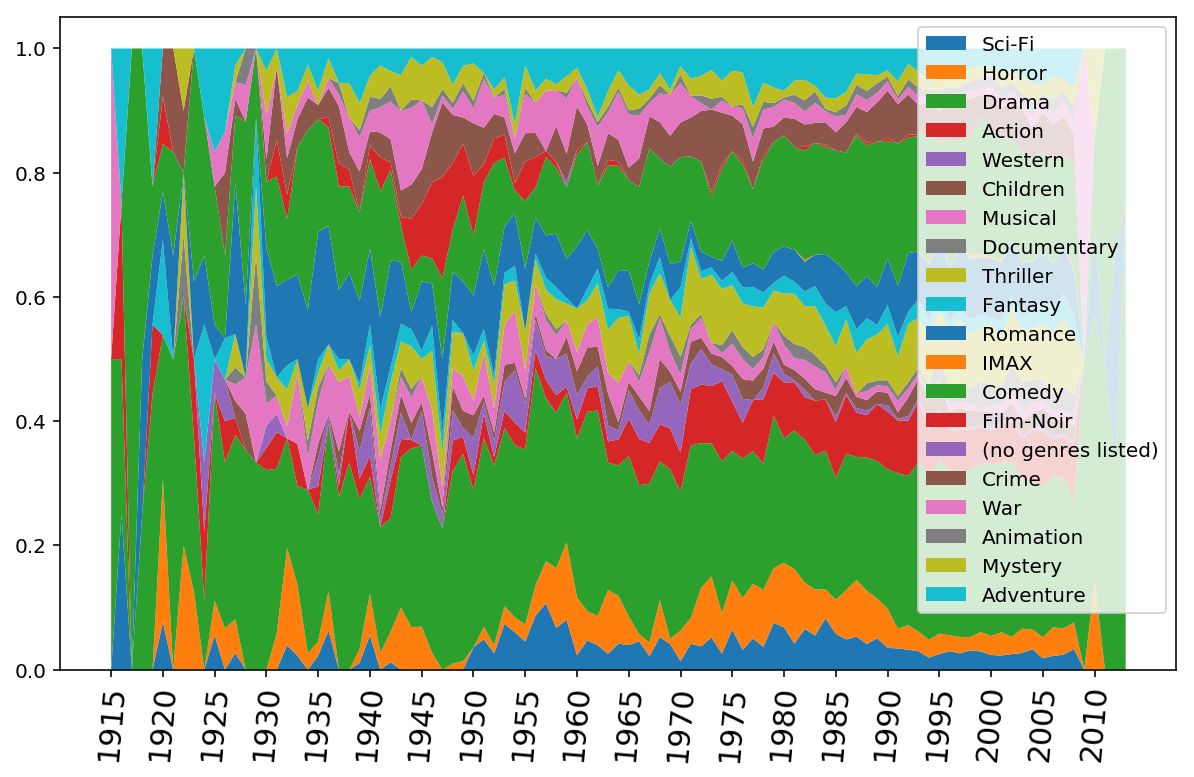

In [191]:
f, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(years, ratios, labels = genres_names)
plt.xticks(years[::5], rotation=85, fontsize=15)
ax.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [41]:
revenue = tmdb\
    .filter(lambda key_value: key_value[1].get('revenue', None) != None)\
    .mapValues(lambda rec: rec['revenue'])\
    .join(genres_tmdb)\
    .keyBy(lambda arr: arr[1][1])\
    .mapValues(lambda arr: (arr[1][0], 1))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda rev: rev[0] / rev[1])
revenue.take(5)

[('Musical', 30816139.91916859),
 ('Children', 80574409.60571429),
 ('Documentary', 1967964.1901709402),
 ('Romance', 30469050.830154948),
 ('Sci-Fi', 60341350.110497236)]

In [42]:
budget = tmdb\
    .filter(lambda key_value: key_value[1].get('budget', None) != None)\
    .mapValues(lambda rec: rec['budget'])\
    .join(genres_tmdb)\
    .keyBy(lambda arr: arr[1][1])\
    .mapValues(lambda arr: (arr[1][0], 1))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda rev: rev[0] / rev[1])
budget.take(5)

[('Musical', 8078574.217090069),
 ('Children', 24860636.956190474),
 ('Documentary', 348121.2991452991),
 ('Romance', 9773639.538736591),
 ('Sci-Fi', 22372462.54281768)]

In [49]:
roi = revenue\
    .join(budget)\
    .filter(lambda key_value: key_value[1][0] != 0 and key_value[1][1] != 0)\
    .mapValues(lambda arr: arr[0] / arr[1])\
    .collect()
roi[:5]

[('Musical', 3.8145518121226933),
 ('Children', 3.241043652570241),
 ('Documentary', 5.653099063466237),
 ('Romance', 3.1174723304859664),
 ('Sci-Fi', 2.697125986690672)]

In [50]:
roi = sorted(roi, key=lambda key_value: key_value[1], reverse=True)
roi[:5]

[('Documentary', 5.653099063466237),
 ('IMAX', 4.26602962987887),
 ('Musical', 3.8145518121226933),
 ('Animation', 3.4253689290610496),
 ('Children', 3.241043652570241)]

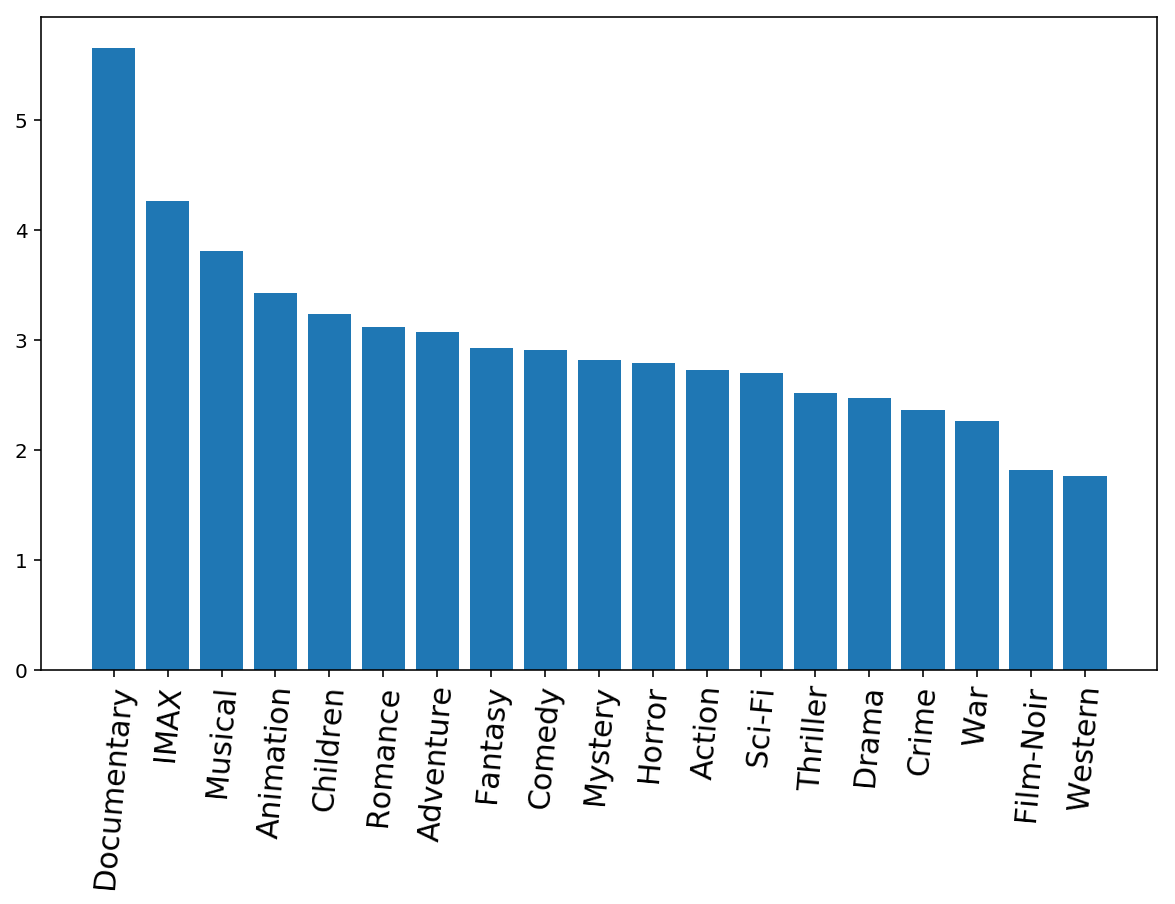

In [51]:
keys, values = zip(*roi)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()